# Final Project A/B Testing

The goal of this project is to test the changes in conversion rates into the different stages of the funnel, for an international online store that introduced an improved recommendation system. This A/B testing analysis will help to determine the influence and efficiency of the new system on the app's users.  

**A/B Test Design**
- Test name: recommender system test
- Groups: А (control), B (new payment funnel)
- Launch date: 2020-12-07
- Date when they stopped taking up new users: 2020-12-21
- End date: 2021-01-01
- Audience: 15% of the new users from the EU region
- Purpose of the test: testing changes related to the introduction of an improved recommendation system
- Main goal of the test: ntroduction of a new recommender system to increase conversion by at least 10% at each stage of the funnel, within 14 days of signing up.
- Expected number of test participants: 6000

## Data Overview

In [219]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
import numpy as np
import math as mth
from scipy import stats as st

In [220]:
marketing_events = pd.read_csv('/datasets/ab_project_marketing_events_us.csv')
users = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv')
user_events = pd.read_csv('/datasets/final_ab_events_upd_us.csv')
participants = pd.read_csv('/datasets/final_ab_participants_upd_us.csv')

In [221]:
datasets = [marketing_events, users, user_events, participants]
for i in datasets:
    display(i.head())
    print(i.info())

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB
None


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB
None


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB
None


## Data Preprocessing 

**Data types conversion**<br>
The date columns should be converted to datetime type. Those were found in the marketing_events, users and user_events datasets.<br>
Changing data types:

In [222]:
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'], format='%Y-%m-%d')
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'], format='%Y-%m-%d')
users['first_date'] = pd.to_datetime(users['first_date'], format='%Y-%m-%d')
user_events['event_dt'] = pd.to_datetime(user_events['event_dt'], format='%Y-%m-%d %H:%M:%S')

**Missing values and duplicates**

There are missing values only in the 'details' column in the user_events dataset. The values in this column represent the price of the purchase, and the missing values correspond to the other stages in the funnel that took place before / without purchase.
Hence, those missing values are not issue in the data and no need to address them. <br>
According to our assumption, the number of purchase events should be equal to the number of non-null values in this dataset:

In [223]:
len(user_events[user_events['event_name'] == 'purchase']) == user_events['details'].notna().sum()

True

Checking across all the datasets to make sure:

In [224]:
for i in datasets:
    print(i.isna().sum())
    print()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

user_id       0
first_date    0
region        0
device        0
dtype: int64

user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64

user_id    0
group      0
ab_test    0
dtype: int64



Looking for duplicates:

In [225]:
for i in datasets:
    print(i.duplicated().sum()) 

0
0
0
0


Single out in a new column the date from event date and time from user_event dataset: 

In [226]:
user_events['date'] = user_events['event_dt'].dt.date
user_events.head()

,user_id,event_dt,event_name,details,date
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07


Converting the new date column to datetime type:

In [227]:
user_events['date'] = pd.to_datetime(user_events['date'], format='%Y-%m-%d')

Total number of users in the data:

In [228]:
users['user_id'].nunique()

58703

**Intermediate conclusions**<br>
The data consists of 4 datasets for marketing, all users, users who participated in the A/B test, and users' events. There were missing values only in 'details' column of the user_events dataset, that correspond to events other than purchase (no item price to display) and thus shouldn't be addressed.<br>The date columns were initially of 'object' type, so we converted to 'datetime' type, and added a new column for date only.<br>

## Exploratory data analysis

Checking the date range of new users sign up:

In [229]:
users['first_date'].min(), users['first_date'].max()

(Timestamp('2020-12-07 00:00:00'), Timestamp('2020-12-23 00:00:00'))

The date range of the new users enrollment exceeded the defined limit of the test - 2020-12-21, by 2 days.

Checking the start and end day of the test by the time the first and last event records: 

In [230]:
user_events['date'].min(), user_events['date'].max()

(Timestamp('2020-12-07 00:00:00'), Timestamp('2020-12-30 00:00:00'))

The dates match the test conditions - start at 2020-12-07, ends at 2020-12-30.

For further analysis, we'll focus on users that were assigned to the recoommender system test, and check through the next stages whether this group satisfy the conditions in the test description. <br>
Counting the number of participants in the recommender test, and the number of users in each test group:

In [231]:
total_count = participants.query("ab_test == 'recommender_system_test'").shape[0]
control_count = participants.query("ab_test == 'recommender_system_test' & group == 'A'").shape[0]
test_count = participants.query("ab_test == 'recommender_system_test' & group == 'B'").shape[0]
print('Total number of participants in the test:', total_count)
print('Number of participants in the control group (A):', control_count)
print('Number of participants in the test group (B):', test_count)
print('Share of control users:', control_count / total_count)
print('Share of test users:', test_count / total_count)

Total number of participants in the test: 3675
Number of participants in the control group (A): 2747
Number of participants in the test group (B): 928
Share of control users: 0.747482993197279
Share of test users: 0.2525170068027211


The total number of participants is much smaller than expected, as only 3675 participants were assigned to the recommender system test, and not 6000 as noted in the description. Moreover, the control group is nearly 3 times bigger than the test group. <br> The groups allocation ratio of the test is 75/25 (control/test).

To meet the test conditions in terms of users sign up date, we'll filter the users table, dropping the users that signed up after the 2020-12-21:

In [232]:
users_filtered = users.query("first_date < '2020-12-22'")
users_filtered['first_date'].max()

Timestamp('2020-12-21 00:00:00')

Storing the relevant users (recommender test users) data from partiipants dataset in a new variable, and merge it with the users_filtered and user_events tables on the 'user_id' column, gathering all the required information in one table:

In [233]:
recommender = participants.query("ab_test == 'recommender_system_test'")
new_data = recommender.merge(user_events, on='user_id', how='left').merge(
    users_filtered, on='user_id', how='left').drop('ab_test', axis=1)
new_data.sample(3)

,user_id,group,event_dt,event_name,details,date,first_date,region,device
23574,B42B2F5EE526472B,A,2020-12-20 08:04:13,login,NaN,2020-12-20,2020-12-10,N.America,Android
14050,52A0547B1B31907F,A,2020-12-23 18:39:46,login,NaN,2020-12-23,2020-12-19,EU,PC
5488,10387B8D694D539C,A,2020-12-21 01:04:40,login,NaN,2020-12-21,2020-12-21,EU,Mac


According to the technical description, the A/B test is based on users data for the first 14 days since sign up. To make this filter, we'll add a column of user lifetime and continue the analysis only with the data that falls within the defined lifetime for each user:

In [234]:
new_data['lifetime'] = new_data['first_date'] + timedelta(days=14)
new_data.sample(3)

,user_id,group,event_dt,event_name,details,date,first_date,region,device,lifetime
15202,91E39AA34D6D1173,A,2020-12-28 01:19:04,login,NaN,2020-12-28,2020-12-19,EU,Android,2021-01-02
18357,6E70E8AF0F6F0B0A,B,2020-12-21 16:27:30,purchase,4.99,2020-12-21,2020-12-20,EU,Android,2021-01-03
15743,EDD9BBF4D05CE79E,A,2020-12-21 22:27:21,login,NaN,2020-12-21,2020-12-18,EU,PC,2021-01-01


Now we'll check the share of the new data users from EU region of all new users from EU region:

In [235]:
all_EU = users_filtered.groupby('region')['user_id'].nunique().reset_index().sort_values(
    by='user_id', ascending=False)
all_EU

,region,user_id
2,EU,39466
3,N.America,8243
1,CIS,2875
0,APAC,2856


In [236]:
test_EU = new_data.groupby('region')['user_id'].nunique().reset_index().sort_values(
    by='user_id', ascending=False)
test_EU

,region,user_id
2,EU,3481
3,N.America,119
0,APAC,45
1,CIS,30


Deviding the EU participiants by the total EU new users to calculate the share:

In [237]:
test_EU[test_EU['region'] == 'EU']['user_id'].iloc[0] /\
all_EU[all_EU['region'] == 'EU']['user_id'].iloc[0] * 100

8.82025034206659

The share of EU participants in the test is 8.8% of the new users from the EU region, which presents a lower value than the expected 15% of EU users.

Before studying the A/B test results, we'll drop the events that were registered after the lifetime date, as described in the test description: <br>
(the 'date' column represents the date component of the event)

In [238]:
new_data = new_data.query('date <= lifetime')

**Conversion at different funnel stages**

First we'll find the number of actions performed for each event in the funnel:

In [239]:
events_funnel = new_data.groupby(['event_name'])['user_id'].nunique().sort_values(ascending=False)
events_funnel

event_name
login           3674
product_page    2303
purchase        1128
product_cart    1079
Name: user_id, dtype: int64

As we can see there are more purchase actions than product_cart, even though the latter usually precedes in the funnel stages. That is probably due to a direct or quick purchase option that skips the product cart page.

Displaying The funnel in the right sequence:

In [240]:
events_funnel.reset_index().reindex([0,1,3,2])

,event_name,user_id
0,login,3674
1,product_page,2303
3,product_cart,1079
2,purchase,1128


Checking the number of events distribution by date:

<Figure size 720x432 with 0 Axes>

<AxesSubplot:xlabel='event_dt', ylabel='Count'>

Text(0.5, 1.0, 'Number of events by date distribution')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Number of events')

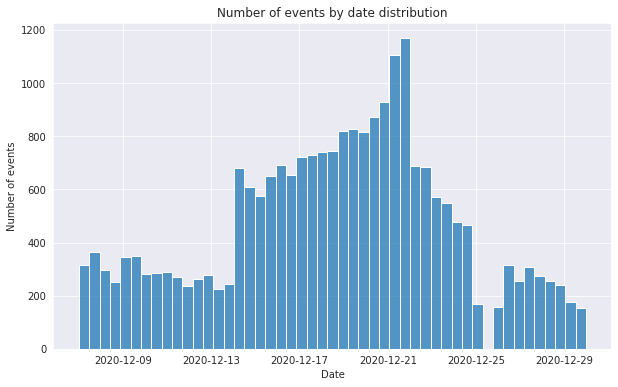

In [241]:
plt.figure(figsize=(10,6))
sns.histplot(data=new_data, x='event_dt')
sns.set_style('darkgrid')
plt.title('Number of events by date distribution')
plt.xlabel('Date')
plt.ylabel('Number of events')
plt.show()

The events by date distribution shows that most of the events have been recorded between 2020-12-14 to 2020-12-24, with a peak value at the day of 2020-12-21. For some reason there was no traffic of events at 2020-12-25. <br>
Study of the marketing data to check foe possible relationship between the marketing events and the increase in users events:

In [242]:
marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


Lets take a look only at the events that preceded the test period - November-December 2020:

In [243]:
marketing_events.query("start_dt > '2020-11-01'")

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07
12,Single's Day Gift Promo,APAC,2020-11-11,2020-11-12


Out of the filtered events, the new year marketing event started by the end of December at the days when the test ended. <br>
The Single's Day event was advertised only in Asia-Pacific (APAC) region, so the Black Friday Ads Campaign is the only marketing event that could have influenced the users across all regions. However, this campaign ended at 2020-12-01 and it seems improbable that is account for the peak values of events at the 14th and 21th of December 2020.

Now we'll look at the distribution of each group in one plot:

<Figure size 720x432 with 0 Axes>

<AxesSubplot:xlabel='event_dt', ylabel='Count'>

<AxesSubplot:xlabel='event_dt', ylabel='Count'>

Text(0.5, 1.0, 'Number of events by date distribution, control vs test group')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Number of events')

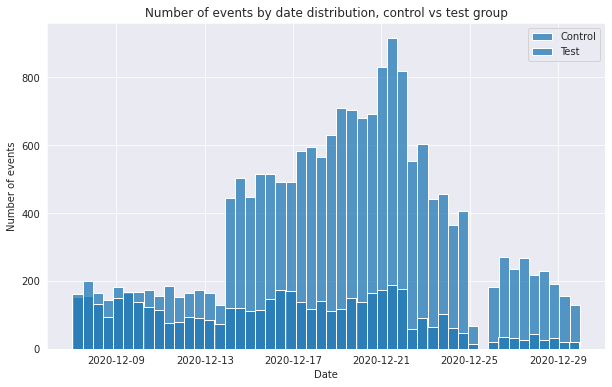

In [245]:
control_data = new_data.query("group == 'A'")
test_data = new_data.query("group == 'B'")
plt.figure(figsize=(10,6))
sns.histplot(data=control_data, x='event_dt', label='Control', bins=50)
sns.histplot(data=test_data, x='event_dt', label='Test', bins=50)
sns.set_style('darkgrid')
plt.title('Number of events by date distribution, control vs test group')
plt.xlabel('Date')
plt.ylabel('Number of events')
plt.legend()
plt.show()

The events by date distribution for the two samples shows that the control group distribution is similar in shape to the overall distribution of events over time. It seems plausible given the relative large share of this group. On the other hand, the test group differs in the traffic at the mid-range days, as we can notice of only a slight increse in number of events between the 14-24 of December.

**Number of events per user distribution among the samples**<br>

Calculating total number of events and average number of events per user for control and test group:

In [246]:
print('Total number of events in the control group:', 
      new_data.query("group == 'A'")['event_dt'].count())
print('Total number of events in the test group:', 
      new_data.query("group == 'B'")['event_dt'].count())
print()
print('Average number of events per user in the control group:',  
      new_data.query("group == 'A'").groupby(['user_id'])['event_dt'].count().mean())
print('Average number of events per user in the test group:', 
      new_data.query("group == 'B'").groupby(['user_id'])['event_dt'].count().mean())

Total number of events in the control group: 18315
Total number of events in the test group: 5047

Average number of events per user in the control group: 6.667273389151802
Average number of events per user in the test group: 5.438577586206897


The average number of events per user is quite similar between the groups, as users in the control group performed 6.7 actions in average, while the corresponding value in the test group is 5.4.

Plotting histogram to present the distribution of number of events per user for each group:

In [247]:
A_events_count = new_data.query("group == 'A'").groupby\
(['user_id'])['event_dt'].count().reset_index().rename(columns={'event_dt' : 'number_of_events'})\
.sort_values(by='number_of_events', ascending=False)
B_events_count = new_data.query("group == 'B'").groupby\
(['user_id'])['event_dt'].count().reset_index().rename(columns={'event_dt' : 'number_of_events'})\
.sort_values(by='number_of_events', ascending=False)
A_events_count.head()
A_events_count.describe()

,user_id,number_of_events
307,1BFEE479308EFF44,24
2230,CED71698585A2E46,24
1175,6E3DF9C69A6B607E,21
2020,BBBFC0C64CC3C05D,20
1270,77FC0E20AEAC1506,20


,number_of_events
count,2747.000000
mean,6.667273
std,3.696512
min,1.000000
25%,4.000000
50%,6.000000
75%,9.000000
max,24.000000


In [248]:
B_events_count.head()
B_events_count.describe()

,user_id,number_of_events
52,115EBC1CA027854A,24
54,1198061F6AF34B7B,24
487,89545C7F903DBA34,21
448,7E8720DB6A21CF66,20
923,FE76759FE6BF8C68,20


,number_of_events
count,928.000000
mean,5.438578
std,3.288452
min,1.000000
25%,3.000000
50%,4.000000
75%,7.000000
max,24.000000


<Figure size 720x432 with 0 Axes>

<AxesSubplot:xlabel='number_of_events', ylabel='Count'>

<AxesSubplot:xlabel='number_of_events', ylabel='Count'>

Text(0.5, 1.0, 'Number of events per user distribution')

Text(0.5, 0, 'Number of events')

Text(0, 0.5, 'Number of users')

(0.0, 24.0)

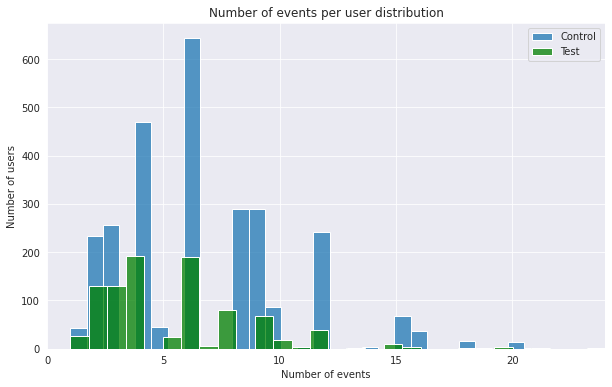

In [249]:
plt.figure(figsize=(10,6))
sns.histplot(A_events_count['number_of_events'], label='Control')
sns.histplot(B_events_count['number_of_events'], label='Test', color='green')
sns.set_style('darkgrid')
plt.title('Number of events per user distribution')
plt.xlabel('Number of events')
plt.ylabel('Number of users')
plt.xlim(0,24)
plt.legend()
plt.show()

The number of events per user distribution shows that most of the users performed 4 or 6 events. There's also a noticeable amount of users who performed 2,3,8 or 9 events.

**How long it takes for a new user to make a purchase**<br>
Another interesting point that we should investigae is the period of time between sign up (login) and purchase. This factor might provide us with useful information on users behavior.<br>
For this purpose we'll filter the data by users who made a purchase. Then calculate the time between the first occurence of the two events:

In [251]:
time_to_purchase = new_data.pivot_table(index='user_id', columns='event_name', values=['event_dt'], 
                                        aggfunc='min')['event_dt']
time_to_purchase = time_to_purchase.reset_index()
time_to_purchase.head()

event_name,user_id,login,product_cart,product_page,purchase
0,001064FEAAB631A1,2020-12-20 14:43:27,NaT,2020-12-20 14:43:28,NaT
1,0010A1C096941592,2020-12-17 21:07:27,NaT,2020-12-17 21:07:27,2020-12-17 21:07:27
2,00341D8401F0F665,2020-12-21 11:14:50,NaT,NaT,NaT
3,003DF44D7589BBD4,2020-12-17 06:17:49,2020-12-17 06:17:49,2020-12-17 06:17:49,NaT
4,00505E15A9D81546,2020-12-14 17:28:32,NaT,NaT,NaT


In [252]:
time_to_purchase['time_to_purchase'] = time_to_purchase['purchase'] - time_to_purchase['login']
time_to_purchase.head()

event_name,user_id,login,product_cart,product_page,purchase,time_to_purchase
0,001064FEAAB631A1,2020-12-20 14:43:27,NaT,2020-12-20 14:43:28,NaT,NaT
1,0010A1C096941592,2020-12-17 21:07:27,NaT,2020-12-17 21:07:27,2020-12-17 21:07:27,0 days
2,00341D8401F0F665,2020-12-21 11:14:50,NaT,NaT,NaT,NaT
3,003DF44D7589BBD4,2020-12-17 06:17:49,2020-12-17 06:17:49,2020-12-17 06:17:49,NaT,NaT
4,00505E15A9D81546,2020-12-14 17:28:32,NaT,NaT,NaT,NaT


Distribution of values for time to purchase column:

In [253]:
time_to_purchase['time_to_purchase'].value_counts()

0 days 00:00:00      1114
0 days 16:39:05         1
0 days 10:56:45         1
-2 days +15:35:23       1
-3 days +15:11:11       1
-3 days +06:16:53       1
6 days 12:53:43         1
-2 days +21:20:14       1
0 days 16:44:31         1
-3 days +12:02:00       1
-6 days +08:35:02       1
-1 days +01:38:50       1
0 days 16:53:14         1
0 days 09:44:00         1
Name: time_to_purchase, dtype: int64

Checking the zero values of time difference:

In [254]:
time_to_purchase[time_to_purchase['time_to_purchase'].dt.days == 0].head()

event_name,user_id,login,product_cart,product_page,purchase,time_to_purchase
1,0010A1C096941592,2020-12-17 21:07:27,NaT,2020-12-17 21:07:27,2020-12-17 21:07:27,0 days
5,005E096DBD379BCF,2020-12-21 07:20:39,NaT,NaT,2020-12-21 07:20:39,0 days
7,0082295A41A867B5,2020-12-16 07:06:32,2020-12-16 07:06:32,2020-12-16 07:06:33,2020-12-16 07:06:32,0 days
9,00C1F5175586DFCF,2020-12-21 16:12:27,NaT,2020-12-21 16:12:32,2020-12-21 16:12:27,0 days
13,01157AAD4401952B,2020-12-18 00:07:20,NaT,2020-12-18 00:07:20,2020-12-18 00:07:20,0 days


The vast majority of purchases was registered at exactly the same time as the login, with or without product page and product cart visit. This finding might be a result of a direct purchase option that enables the user to buy without going through the whole funnel. If so, it seems that this feature gained a huge popularity among the buyers and is the preferable purchase channel.<br>
Additionaly, there are negative values in the time difference column.<br> 
Lets check those observations:

In [255]:
time_to_purchase[time_to_purchase['time_to_purchase'].dt.days < 0]

event_name,user_id,login,product_cart,product_page,purchase,time_to_purchase
710,3242BDDFA690A22B,2020-12-10 06:08:54,NaT,2020-12-10 06:08:54,2020-12-07 18:10:54,-3 days +12:02:00
1921,89143F0AEFE3B11D,2020-12-08 06:42:18,NaT,NaT,2020-12-07 08:21:08,-1 days +01:38:50
2028,8FF91E21E27A330D,2020-12-08 10:22:07,2020-12-08 10:22:08,2020-12-08 10:22:09,2020-12-07 01:57:30,-2 days +15:35:23
2347,A5392D494EB71414,2020-12-10 15:39:20,NaT,2020-12-10 15:39:23,2020-12-07 21:56:13,-3 days +06:16:53
2808,C3C56A2DFF10BC79,2020-12-13 04:41:30,2020-12-13 04:41:31,NaT,2020-12-07 13:16:32,-6 days +08:35:02
2883,C7CB2F1BA42F102B,2020-12-08 05:44:51,2020-12-08 05:44:51,NaT,2020-12-07 03:05:05,-2 days +21:20:14
3520,F4C8BB8D1622FE87,2020-12-09 19:16:52,2020-12-09 19:16:52,2020-12-09 19:16:52,2020-12-07 10:28:03,-3 days +15:11:11


We found several observations where the purchase event was registered before the login. We can assume that this happened either for a similar reson to the above mentioned - the option of buying without performing the login action, or because of some registration error that occured at that day (all the above purchases were made at 2020-12-07).<br>
Anyway, we can conclude that most users who make a purchase do it at the day of login.

**Users who are present in both samples** <br>

We'll check if there are any users who were allocated to both groups - A and B. We already created a filtered dataset for the recommender test participants, so it's left to group by user and count the groups related to each user, presenting only cases of more than one allocation (if any):

In [256]:
recommender.groupby(['user_id'])['group'].nunique().reset_index().query('group > 1')

,user_id,group


No users were allocated to both samples of the recommender test.

**The Interface EU Test**<br>
For the sake of analysis, we'll briefly investigate the other test that was conducted and recored in the data under the name 'interface_eu_test'.

As we did in this EAD part, we'll filter the participant dataset by the relevant A/B test, count the number of participants in each group, and merge the filtered data with the information on users and their events.

Filtering, and counting number of participants:

In [257]:
interface = participants[participants['ab_test'] == 'interface_eu_test']
interface_control = interface.query("group == 'A'")
interface_test = interface.query("group == 'B'")
print('Total number of participants in the interface test:', interface.user_id.nunique())
print('Number of participants in control group:', interface_control.shape[0])
print('Number of participants in test group:', interface_test.shape[0])

Total number of participants in the interface test: 10850
Number of participants in control group: 5467
Number of participants in test group: 5383


Merging the tables:

In [258]:
interface_eu = interface.merge(users, on='user_id', how='left').merge(
    user_events, on='user_id', how='left')
interface_eu.head()

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,date
0,D4E530F6595A05A3,A,interface_eu_test,2020-12-22,EU,Android,2020-12-22 06:01:01,product_cart,NaN,2020-12-22
1,D4E530F6595A05A3,A,interface_eu_test,2020-12-22,EU,Android,2020-12-26 09:31:53,product_cart,NaN,2020-12-26
2,D4E530F6595A05A3,A,interface_eu_test,2020-12-22,EU,Android,2020-12-29 23:35:45,product_cart,NaN,2020-12-29
3,D4E530F6595A05A3,A,interface_eu_test,2020-12-22,EU,Android,2020-12-22 06:00:57,login,NaN,2020-12-22
4,D4E530F6595A05A3,A,interface_eu_test,2020-12-22,EU,Android,2020-12-26 09:31:53,login,NaN,2020-12-26


Checking for users multiple allocation to groups:

In [259]:
interface_eu.groupby(['user_id'])['group'].nunique().reset_index().query('group > 1')

,user_id,group


Checking for users regions and the share EU users:

In [260]:
interface_eu['region'].unique()

array(['EU'], dtype=object)

Only users from EU region were included in the data.

Share of EU participants of all new EU users:

In [261]:
interface['user_id'].nunique() / all_EU[all_EU['region'] == 'EU']['user_id'].iloc[0] * 100

27.49201844625754

The test audience: 27.5% of all the new users from EU region.

Checking the date range of events and of sign up:

In [262]:
interface_eu[['event_dt','first_date']].describe().loc[['first','last']]

/tmp/ipykernel_27/2207410069.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  interface_eu[['event_dt','first_date']].describe().loc[['first','last']]
/tmp/ipykernel_27/2207410069.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  interface_eu[['event_dt','first_date']].describe().loc[['first','last']]


,event_dt,first_date
first,2020-12-07 00:02:48,2020-12-07 00:00:00
last,2020-12-30 18:28:55,2020-12-23 00:00:00


The dates range is similar for both tests.

**Peculiarities in the data to take into account before starting the A/B test**

There are a few issues to consider before cunducting the A/B test. <br>
As mentioned before, there is a larger amount of events for purchase stage than for the product cart stage, which is the preceding stage of the traditional funnel. We could assume that this fact might be related to the new payment system, but this unexpected order of events is present in the control group as well. Hence, this is probably due to a quick payment path that takes the user from the product page right to the purchase page without going through the product cart.<br>
Moreover, we found that most of the purchases were recorded at the same time as the login of these users, and a few purchases even before the login.<br>
Oddly enough, some of technical description conditions were satisfied by the inerface eu test data, as this test included only users from EU region, more than 10,850 particpants overall, which are 27.5% of all the new users from EU region, and were almost equally allocated to control/test groups. <br>Even without proceeding to the A/B test results of the interface_eu_test, in a the real life environment we would better inform the managers of these findings before moving further.  

## Evaluation of A/B test results 

**Notes about the A/B test results**<br>
As explored and investigated in the former stages of the project, the data for the recommender system test analysis doesn't (or patially) meet the conditions of the test as documented in the technical description. The last date of taking up new users, the audience share of the new EU users, and the number of test participants - don't match the technical desciption.<br>
Furthermore, the test was conducted with an unequal allocation of users, as the number of participants in the control group is nearly 3 times bigger than the test group.<br>
These findings might affect the strength of our A/B test, thus influence the results, and maybe the validity of our conclusions and should be taken into account. 

Based on our filtered and preprocessed data, we'll create the event funnel for both groups together, and for each group seperately:

In [263]:
funnel = new_data.groupby(['event_name'])['user_id'].nunique().reset_index().sort_values(
    by='user_id', ascending=False)
funnel

,event_name,user_id
0,login,3674
2,product_page,2303
3,purchase,1128
1,product_cart,1079


Changing the order of the funnel events to the right sequence, through reindex:

In [264]:
funnel = funnel.reindex([0,2,1,3])
funnel

,event_name,user_id
0,login,3674
2,product_page,2303
1,product_cart,1079
3,purchase,1128


Calculating the change in number of users (conversion) between stages, adding the change in percentage between events in a new column:

In [265]:
funnel['change(%)'] = funnel['user_id'].pct_change()
funnel

,event_name,user_id,change(%)
0,login,3674,NaN
2,product_page,2303,-0.373163
1,product_cart,1079,-0.531481
3,purchase,1128,0.045412


The funnel above shows a decrease of 37% in the number of users from login product page visit. We observe an increase of 4% from product cart to purchase (for the reasons we discussed eraleir). However, this increase comes after a drop of 53% from product page to pruduct cart, means that about 50% of the users who viewed the product page made a purchase.

Now we'll comapre the funnels of the control and test groups and find the differences in the funnel events (including the reindexing as in the overall funnel): 

In [266]:
control_funnel = new_data.query("group == 'A'").groupby(
    ['event_name'])['user_id'].nunique().reset_index().sort_values(
    by='user_id', ascending=False).reindex([0,2,1,3])
control_funnel['change(%)'] = control_funnel['user_id'].pct_change()

test_funnel = new_data.query("group == 'B'").groupby(
    ['event_name'])['user_id'].nunique().reset_index().sort_values(
    by='user_id', ascending=False).reindex([0,2,1,3])
test_funnel['change(%)'] = test_funnel['user_id'].pct_change()
print('Control group:')
control_funnel
print('Test group:')
test_funnel

Control group:


,event_name,user_id,change(%)
0,login,2747,NaN
2,product_page,1780,-0.352020
1,product_cart,824,-0.537079
3,purchase,872,0.058252


Test group:


,event_name,user_id,change(%)
0,login,927,NaN
2,product_page,523,-0.435814
1,product_cart,255,-0.512428
3,purchase,256,0.003922


The upper table is the control group's funnel, and the lower is the test group's funnel.<br>
The difference between grups in conversion into the funnels late stages - product cart and purchase - remains uncertain. The test group presents a bit lower dorp (51%) from product page to product cart in comparison to the control group (54%), but this is followed by a smaller increase into purchase. Moreover, relatively less users visited the product page in the test group (drop of 43% from login stage) in comparison to the control group (drop of 35%).<br>
Back to the test conditions and goals, the new recommendation system failed to improve the conversion for the test group funnel by the desired rates, and haven't reached the target of a 10% increase.<br>
To make things clearer we'll compare only the change from login to purchase between the groups:

In [267]:
print('Control group login to purchase change:')
control_funnel.query("event_name == 'login' or event_name == 'purchase'")['user_id'].pct_change().iloc[1]
print('Test group login to purchase change:')
test_funnel.query("event_name == 'login' or event_name == 'purchase'")['user_id'].pct_change().iloc[1]

Control group login to purchase change:


-0.6825627957772116

Test group login to purchase change:


-0.7238403451995685

The filtered funnels shows difference between the groups in the relative share of users who made a purchase. The control group got better results in this comparison, with a 4% larger share of users who made a purchase than the the test group (drop of -68%, -72% respectively).

Creating a pivot table with the number of users that performed each event for each group:

In [269]:
test_pivot = new_data.pivot_table(
    index='event_name', columns='group', values='user_id', aggfunc='nunique').reset_index()\
.sort_values(by='A', ascending=False)
test_pivot

group,event_name,A,B
0,login,2747,927
2,product_page,1780,523
3,purchase,872,256
1,product_cart,824,255


**The statistical difference between the proportions**<br>
To determine whether the difference in the conversion at the stages of the funnel between groups is statistically significant, we'll use the Z-test of proportions.<br>
In terms of the Z-test, the total nubmer of users in each group is the trials, and the number of users who performed each stage is the success.


The test hypotheses:
- H0: There is no difference between the experimental groups in the funnel stage proportions.
- H1: The experimental groups differ in the proportions at the funnel stage.


Creating a function of Z-test for control and test groups:

In [270]:
def z_test(event, alpha=0.05):

    """
    This function takes a given event of the funnel as an argument, runs a Z-test to check the 
    statistical difference between groups in the proportions, and return p-value to determine 
    whether we can or can't reject the null hypothesis
    """
    
    success1 = test_pivot[test_pivot['event_name'] == event]['A'].iloc[0]
    success2 = test_pivot[test_pivot['event_name'] == event]['B'].iloc[0]
    
    trials1 = new_data[new_data['group'] == 'A']['user_id'].nunique()
    trials2 = new_data[new_data['group'] == 'B']['user_id'].nunique()
    
    p1 = success1/trials1
    p2 = success2/trials2
    p_combined = (success1 + success2) / (trials1 + trials2)
    difference = p1 - p2
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)
    if p_value > alpha:
        print("We can't reject the null hypothesis")
    else:
        print('We reject the null hypothesis')


In [271]:
z_test('product_page')

p-value:  4.310980554755872e-06
We reject the null hypothesis


The p-value from the Z-test for product page event is far below the threshold for statistical significnce, means that we reject the null hypothesis as there's a significant difference between the control anf test group in the conversion at this stage of the funnel.

In [272]:
z_test('product_cart')

p-value:  0.14534814557238196
We can't reject the null hypothesis


Concerning the product cart event the p-value of the Z-test is greater than the alpha value. That is, we can't reject the null hypothesis as there's no statistically significant difference between the groups in the conversion rate to this stage.

In [273]:
z_test('purchase')

p-value:  0.017592402663314743
We reject the null hypothesis


In the Z-test for purchase stage, the p-value indicates a significant difference between the groups, and the null hypothesis is rejected.

**The significance level, number of tests, and probability of a false conclusion**

In the above hypotheses testing we set the statistical significnace threshold (alpha) to the common value of 0.05. However, testing the same population / samples multiple times increase the probability of making an error. According the FWER (Family-wise error rate) probability formula, the probability of error while running our test once with alpha=0.05 would be 5% ( 1 - (1 - 0.05) = 0.05). But if we run this test 3 times with an alpha level of 5% like we did, the FWER is 14% ( 1 - (1 - 0.05)**3 = 0.14).
To prevent this probability of error from rising, we should use multiple comparison correction such as the Bonferroni correction. According to the Bonferroni correction formula, the alpha value for the set of tests should be the alpha of a single test devided by the number of tests performed. In our case - alpha = 0.05 / 3 = 0.017 (1.7%).<br>
Conducting the Z-tests once again, with the alpha value set to 0.017:

In [274]:
z_test('product_page', 0.017)

p-value:  4.310980554755872e-06
We reject the null hypothesis


In [275]:
z_test('product_cart', 0.017)

p-value:  0.14534814557238196
We can't reject the null hypothesis


In [276]:
z_test('purchase', 0.017)

p-value:  0.017592402663314743
We can't reject the null hypothesis


After the alpha level correction, we see that there's a statistically significant difference in proportions between groups at the product page stage, while no significant difference at the product cart and purchase stages.

## Conclusions 

The main findings and results of the EDA stage and A/B test:

**Exploratory data analysis stage**
- The number of participants (3674), share of users from EU region (8.8%), and last date of users sign up (2020-12-23) - didn't satisfy the recommender system test conditions.  
- The gorups allocation ratio was 75/25 (control/test) 
- The avergae number of events per user is 6.7 for control group and 5.4 for test group. The median values of these distribution are 6 and 4 respectively.
- Most of the users who made a purchase did it at the same day of login, probably thorugh 'one-click' purchase option.
- The order of events in the funnel was login -> product page -> purchase -> product cart, for both groups together and each group seperately. 

**A/B test results**
- The test failed to meet the expectation of 10% increase in conversion into the funnel stages. In fact there was only an insignificant improvemnt of 3% in conversion into product cart, while the conversion rates into product page and purchase were lower for the test group. 
- The Z-test results showed a significant difference between the groups in the proportions of product page, while no difference in product cart and purchase.

Based on the results we would recommend to stop the test, as the new payment system falied to improve the conversion rates into the funnel stages within the 14 days period.<br>
However, we should mention that not all of the test conditions were met in our data on the recommender system test. This fact might have affected the results.